# Project: Investigate a Dataset (TMDb movie data)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

- This data set contains information about 10,000+ movies collected from The Movie Database (TMDb), with data_columns like user ratings, revenue, budget etc. to name a few. I am fond of watching movies in my free time. Hence, I got curious in analyzing movies data and selected this data set for my porject.
- After having superficial look at the data, I have come up with following questions, for which i want to get answers from the dataset :
    1. Top 10 highest grossing movies by revenue (without adjusted inflation).
    2. Top 10 highest grossing movies by revenue (with adjusted for inflation).
    3. Genres with the number movies made in that.
    4. What kinds of properties are associated with movies that have high revenues? (I took this question directly from the example questions give in project details. Of course, I am interested in getting answer to this question)

- First, I have imported all necessary libraries which will be useful throughout the project.
- Also, I have included **%matplotlib inline** to utilize jupyter notebook's magic feature. This line of code will allow me to directly plot graphs in same notebook window as well as without using **plot.show()** function!

In [46]:
#importing all necessary libraries for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#below line is used for showing matplotlib visualizations in same notebook window
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

- For data cleaning, I am loading csv dataset into pandas dataframe. DataFrames have better functionalities as compared to numpy arrays, so i am going with DataFrames.
- Next, I am printing first few rows of dataset to have a superficial look at data as well as data types for each column.
- Then, I am printing datatypes of all the columns to make sure that respective columns have necessary datatypes.

In [47]:
#load data into movies dataframe
movies = pd.read_csv('tmdb-movies.csv')

#printing few rows of dataset
print movies.head()

#printing datatypes of each column in dataframe/table
print movies.dtypes    

       id    imdb_id  popularity     budget     revenue  \
0  135397  tt0369610   32.985763  150000000  1513528810   
1   76341  tt1392190   28.419936  150000000   378436354   
2  262500  tt2908446   13.112507  110000000   295238201   
3  140607  tt2488496   11.173104  200000000  2068178225   
4  168259  tt2820852    9.335014  190000000  1506249360   

                 original_title  \
0                Jurassic World   
1            Mad Max: Fury Road   
2                     Insurgent   
3  Star Wars: The Force Awakens   
4                     Furious 7   

                                                cast  \
0  Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...   
1  Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...   
2  Shailene Woodley|Theo James|Kate Winslet|Ansel...   
3  Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...   
4  Vin Diesel|Paul Walker|Jason Statham|Michelle ...   

                                            homepage          director  \
0                      

- As, We can see in the output, columns **revenue_adj** and **budget_adj** have values in scientific format and their data type is float64.
- But, I need **revenue_adj** and **budget_adj** column values to be in integer format for my analysis. So first, i am converting these column values from float format to integer format
- Lastly, printing their data types to confirm the conversion

In [48]:
#assigning integer data type to revenue_adj and budget_adj columns
movies[['revenue_adj', 'budget_adj']] = movies[['revenue_adj', 'budget_adj']].astype(int)

#print data types of revenue_adj and budget_adj to confirm 
print movies[['revenue_adj', 'budget_adj']].dtypes

revenue_adj    int64
budget_adj     int64
dtype: object


- Other thing, I noticed in output of dataset, is that, there are many unnecessary columns, *which I am neither going to use in analysis nor I am interested in knowing*.
- Thus, I am removing them from the dataset

In [92]:
#checking if 'movies' contains columns to prevent error while re-running this cell
if {'popularity','imdb_id', 'homepage', 'production_companies', 'tagline', 'keywords', 'overview', 
             'release_date'}.issubset(movies.columns):
    #removing unnecessary coulmns from the movies dataframe
    movies.drop(['popularity','imdb_id', 'homepage', 'production_companies', 'tagline', 'keywords', 'overview', 
             'release_date'], axis=1, inplace = True)

- Printing dataframe to confirm the output of previous operation

In [93]:
#print first 5 rows of dataframe
print movies.head(5)

       id     budget     revenue                original_title  \
0  135397  150000000  1513528810                Jurassic World   
1   76341  150000000   378436354            Mad Max: Fury Road   
2  262500  110000000   295238201                     Insurgent   
3  140607  200000000  2068178225  Star Wars: The Force Awakens   
4  168259  190000000  1506249360                     Furious 7   

                                                cast          director  \
0  Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...   Colin Trevorrow   
1  Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...     George Miller   
2  Shailene Woodley|Theo James|Kate Winslet|Ansel...  Robert Schwentke   
3  Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...       J.J. Abrams   
4  Vin Diesel|Paul Walker|Jason Statham|Michelle ...         James Wan   

   runtime                                     genres  vote_count  \
0      124  Action|Adventure|Science Fiction|Thriller        5562   
1      120  Action|A

- While having peripheral look at the original dataset file, I found out that, there are some records with revenue being 0 implying revenue for that perticular movie is not available! Hence, I won't be able to use them for movie revenues related analysis.
- Thus, I will simply filter out the records having non zero revenues. As, adjusted revenues for inflation depend on original revenues, those records, having '0' as revenue_adj value, will be removed too.

In [94]:
#removing all rows with movies, which have revenue = 0$
movies_with_non_zero_revenue = movies[movies.revenue != 0] 

#printing lowest revenue value to confirm only records with non-zero revenues are reamining.
print movies_with_non_zero_revenue['revenue'].min()

2


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.


- For exploring data, first i am defining all helper functions, those can be used multiple times throughout the project

### Helper Functions

<a id='svbc'></a>
### sort_values_by_column

In [95]:
#This function is used to sort the values of dataframe by its column values, in ascending or descending order
def sort_values_by_column(movies_df, col_name,  order, num):
    
    #checking if sort in ascending order or descending order
    if order == 'asc': 
        
        #dataframe.sort_values() function will sort the dataframe rows according to specified column
        sorted_movies = movies_df.sort_values(by=[col_name], ascending=True).head(num)        
    elif order == 'desc':
        sorted_movies = movies_df.sort_values(by=[col_name], ascending=False).head(num)
        
    #assigning custom index to the dataframe
    sorted_movies.index = range(num)
    return sorted_movies

<a id='gp'></a>
### get_percentile

In [96]:
#This function is used for finding certain percentile(i.e. 20th) for given values
def get_percentile(col, percentile):
    
    #quantile function calculates the given percentile value
    return col.quantile(q=percentile)

<a id='tmpc'></a>
### top50_movies_properties_chart

In [97]:
#This function is used for plotting properties of high revenu movies
def top50_movies_properties_chart(y_label, col_name, thresold):
    
    #creating list of 0 to 50
    x = range(50)
    
    #converting column values to list
    y = top50_movies_by_revenue[col_name].tolist()
    plt.figure(figsize=(12,4))
    plt.ticklabel_format(style='plain', axis='y')
    sns.barplot(x, y)
    plt.xlabel('Top 50 Movies in descending order of revenue')
    plt.ylabel(y_label)
    plt.axhline(y=thresold, color='r', linestyle='dashdot', linewidth=1.5)

<a id='pma'></a>
### plot_movies_attrs

In [98]:
#This function is used for plotting movies' attributes like revenue, adjusted revenue and genres
def plot_movies_attrs(movies_df, rev_col, xticks, x_label, y_label):
    x = np.array(range(len(movies_df)))
    y = np.array(movies_df[rev_col].tolist())
    sns.barplot(range(len(movies_df)), y, palette="Blues_d")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(x, xticks, rotation=90)
    plt.ticklabel_format(style='plain', axis='y')

<a id='egw'></a>
### extract_genres_with_moviesInIt

In [99]:
#This function is used for getting genres with number of movies in each genre
def extract_genres_with_moviesInIt(s_genres):   
    
    #applying extract_genre() function over all values of s_genre series
    s_genres.apply(extract_genre)
    df = pd.DataFrame(genre_count, index = [0])
    
    #this will convert rows->columns (or vice versa)
    df = df.transpose()
    return df


<a id='eg'></a>
### extract_genre

In [120]:
# This function is used to extract genres from each cell of the table 
# and create dictonary with genre-genre_count pair
def extract_genre(s):
    
    #checking if 's' is the string instance or not and to prevent error from 'nan' instances
    if isinstance(s, str):        
        list_genres = s.split("|")    
        for g in list_genres:
            if genre_count.has_key(g):
                temp_dict = {g:genre_count.get(g)+1}
                genre_count.update(temp_dict)
            else:
                genre_count.update(({g:1}))     


### Research Question 1 : Top 10 highest grossing movies by revenue (without adjusted inflation)

- For finding top 10 highest grossing movies by revenue, I will simply use helper function <a href="#svbc">sort_values_by_column</a>
- By printing the output dataframe, I get all data, which i am interested in knowing, for top 10 highest grossing movies.

In [101]:
#Using helper function sort_values_by_column() to get the data of top 10 highest grossing movies
top10_movies_df = sort_values_by_column(movies_with_non_zero_revenue, 'revenue', 'desc', 10)

#print the filtered dataframe
print top10_movies_df

       id     budget     revenue  \
0   19995  237000000  2781505847   
1  140607  200000000  2068178225   
2     597  200000000  1845034188   
3   24428  220000000  1519557910   
4  135397  150000000  1513528810   
5  168259  190000000  1506249360   
6   99861  280000000  1405035767   
7   12445  125000000  1327817822   
8  109445  150000000  1274219009   
9   68721  200000000  1215439994   

                                 original_title  \
0                                        Avatar   
1                  Star Wars: The Force Awakens   
2                                       Titanic   
3                                  The Avengers   
4                                Jurassic World   
5                                     Furious 7   
6                       Avengers: Age of Ultron   
7  Harry Potter and the Deathly Hallows: Part 2   
8                                        Frozen   
9                                    Iron Man 3   

                                         

- To get the direct view of top 10 highest grossing movie names and their revenue, I have plotted *movies->revenues* chart below. For this, first i am extracting movie names from top10_movies_df.
- Then, I will simply use helper function <a href="#pma">plot_movies_attrs</a> for plotting.

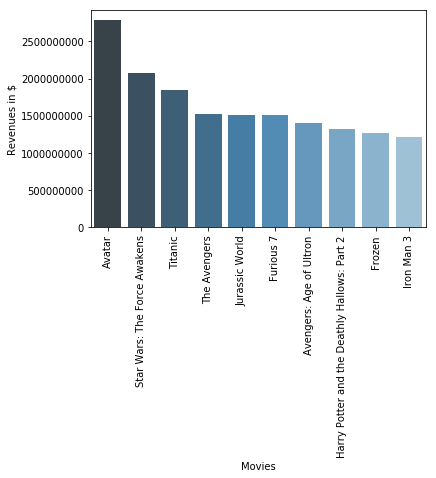

In [102]:
#extracting movie names from top10 movies dataframe
movie_names = top10_movies_df['original_title'].tolist()

#Using helper function plot_movies_attrs() to plot the graph of movie -> revenue
plot_movies_attrs(top10_movies_df, 'revenue', movie_names, 'Movies', 'Revenues in $')

### Research Question 2  (Top 10 highest grossing movies by revenue with adjusting inflation)

- This question is similar to the first question except, here we are talking about top movies with revenues adjusted for inflation. 
- If you look at the function <a href="#svbc">sort_values_by_column</a>, It is implemented in a way, so that, I can just change the argument **col_name** to **revenue_adj** for finding answer to this question.
- And by outputting the filtered dataframe , i got all datapoints,in which i am interested.

In [103]:
#Using helper function sort_values_by_column() to get dataframe of 'top 10 movies by adjusted revenue'
top10_movies_df_adj = sort_values_by_column(movies_with_non_zero_revenue, 'revenue_adj', 'desc', 10)

#printing filtered dataframe
print top10_movies_df_adj

       id     budget     revenue                  original_title  \
0   19995  237000000  2781505847                          Avatar   
1      11   11000000   775398007                       Star Wars   
2     597  200000000  1845034188                         Titanic   
3    9552    8000000   441306145                    The Exorcist   
4     578    7000000   470654000                            Jaws   
5  140607  200000000  2068178225    Star Wars: The Force Awakens   
6     601   10500000   792910554      E.T. the Extra-Terrestrial   
7    1642   22000000  1106279658                         The Net   
8   12230    4000000   215880014  One Hundred and One Dalmatians   
9   24428  220000000  1519557910                    The Avengers   

                                                cast  \
0  Sam Worthington|Zoe Saldana|Sigourney Weaver|S...   
1  Mark Hamill|Harrison Ford|Carrie Fisher|Peter ...   
2  Kate Winslet|Leonardo DiCaprio|Frances Fisher|...   
3  Linda Blair|Max von Sydo

- Similar to question 1, I am plotting chart for *movies->adjusted revenue for inflation* , using <a href="#pma">plot_movies_attrs</a> function for visualization.

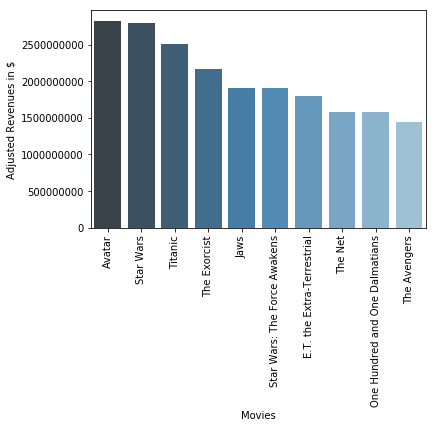

In [104]:
#Extracting movie names from top10 movies dataframe
movie_names = top10_movies_df_adj['original_title'].tolist()

#Plotting movie->adjusted revenue graph by using helper function plot_movies_attrs()
plot_movies_attrs(top10_movies_df_adj, 'revenue_adj', movie_names, 'Movies', 'Adjusted Revenues in $')

### Research Question 3 : Genres with the number movies made in that

- By this question, i intend to find the number of movies made in each genre for the given dataset. When you look at column 'genres' in dataset, you can notice that, each movie falls within multiple genres. 
- For example, **Jurassic Park** movie has genre data something like - *"Action|Adventure|Science Fiction|Thriller"*, which implies jurassic park movie falls in Action, Adventure, Science, Fiction and Thriller genres. So, while counting number of movies for each genre, we will get total genres count greater than total movies. 
- I am using helper function <a href="#egw">extract_genres_with_moviesInIt</a> to get the count of movies for each genre.
- By printing the resultant dataframe, we can get the required values.

In [105]:
# initializing empty dictionary
genre_count = dict()

#using helper function extract_genres_with_moviesInIt() to convert genre dictionary to dataframe
genres_with_genre_count_df = extract_genres_with_moviesInIt(movies['genres'])

#print the dataframe
print genres_with_genre_count_df

                    0
Action           2385
Adventure        1471
Animation         699
Comedy           3793
Crime            1355
Documentary       520
Drama            4761
Family           1231
Fantasy           916
Foreign           188
History           334
Horror           1637
Music             408
Mystery           810
Romance          1712
Science Fiction  1230
TV Movie          167
Thriller         2908
War               270
Western           165


- We can notice from output that, if we take the sum of second cloumn(count of movies), it will be ~25000, which is higher than the total movies=10,866 in dataset. As i explained earlier, single movie might be in multiple genres, that's why we are getting this result.
- I have plotted *genre->no. of movies in it* graph for better understanding of trend.
- I am using function <a href="#pma">plot_movies_attrs</a> for visualizing trend.

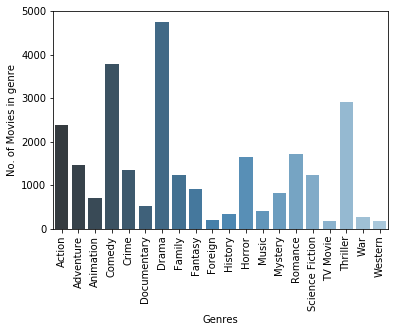

In [106]:
#extracting genre names from genre dataframe
genre_names = genres_with_genre_count_df.index.values.tolist() 

#plotting genre->no. of movie in it graph using helper function plot_movies_attrs()
plot_movies_attrs(genres_with_genre_count_df, 0, genre_names, 'Genres', 'No. of Movies in genre')

- From the plot , we can see that highest number of movies are made in genre **Drama** and lowest number of movies are made in genre **Western**.

### Research Question 4 : What kinds of properties are associated with movies that have high revenues?

- To find the properties associated with movies having high revenues, first i need to find the movies with high revenues.
- I hava already defined the funtion <a href="#svbc">sort_values_by_column</a>, which returns the movies in descending order of their revenue. One of the arguments of this function is *num*. If you pass num=10, then this function will return top 10 movies in order. Likewise, If i pass num=50, it will return top 50 movies by revenue in descending order. 
- Here, I am considering sample of top 50 movies to find the properties of high revenue movies.

In [107]:
#using helper function sort_values_by_column() to extract 'top50 movies by revenue' from the dataframe
top50_movies_by_revenue = sort_values_by_column(movies_with_non_zero_revenue, 'revenue', 'desc', 50)

- Printing top few movies from above filtered dataframe to analyze about possible properties.

In [108]:
#printing few rows of top50_movies_by_revenue
print top50_movies_by_revenue.head()

       id     budget     revenue                original_title  \
0   19995  237000000  2781505847                        Avatar   
1  140607  200000000  2068178225  Star Wars: The Force Awakens   
2     597  200000000  1845034188                       Titanic   
3   24428  220000000  1519557910                  The Avengers   
4  135397  150000000  1513528810                Jurassic World   

                                                cast         director  \
0  Sam Worthington|Zoe Saldana|Sigourney Weaver|S...    James Cameron   
1  Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...      J.J. Abrams   
2  Kate Winslet|Leonardo DiCaprio|Frances Fisher|...    James Cameron   
3  Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...      Joss Whedon   
4  Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...  Colin Trevorrow   

   runtime                                     genres  vote_count  \
0      162   Action|Adventure|Fantasy|Science Fiction        8458   
1      136   Action|Advent

- From above output, I have decided to consider columns **budget, vote_count, vote_average and runtime**, as they have numerical values. So, i will be able to find descriptive statistics easily for them and will be able to compare them to find relevant properties. Also, I have noticed that **genres** column has some genres in common for multiple movies. Thus, i will consider **genres** column too.
- In pandas, we can use describe() function on dataframe to find descriptive statistics.
- Notice that i am passing (0.2,0.5,0.75) as argument to describe function. This will make sure that i get 20%, 50% and 75% percentile values. Default values are 25%, 50% and 75%.
- After playing around with different percentile values for selected columns, I have come up with the conclusion that top 80% movies from top50 movies have common values. So, we can consider this *80% of 50 = 40* movies for *common properties of high revenue movies*. Hence, taking 20 precentile as thresold value.


In [109]:
#find descriptive statistics for top50 movies
top50_movies_stats = top50_movies_by_revenue[['budget', 'vote_count', 'vote_average', 'runtime']].describe \
                     ([0.20, .5, .75])
#print stats    
print top50_movies_stats     

             budget   vote_count  vote_average     runtime
count  5.000000e+01    50.000000     50.000000   50.000000
mean   1.689400e+08  3986.920000      7.006000  138.120000
std    7.289618e+07  2037.739252      0.617569   26.960773
min    2.200000e+07   201.000000      5.600000   88.000000
20%    9.480000e+07  2628.400000      6.380000  112.800000
50%    1.550000e+08  3375.500000      7.150000  142.000000
75%    2.150000e+08  4999.000000      7.400000  152.750000
max    3.800000e+08  9767.000000      8.100000  201.000000


- From the output, it is visible that 'budget' column has scientific values and other columns have values upto 6 decimal points. So, i need to fix this first by rounding these values.

In [110]:
#rounding values of budget coulmn
top50_movies_stats['budget'] = top50_movies_stats['budget'].round()

#print dataframe
print top50_movies_stats.round(3)

            budget  vote_count  vote_average  runtime
count         50.0      50.000        50.000   50.000
mean   168940000.0    3986.920         7.006  138.120
std     72896183.0    2037.739         0.618   26.961
min     22000000.0     201.000         5.600   88.000
20%     94800000.0    2628.400         6.380  112.800
50%    155000000.0    3375.500         7.150  142.000
75%    215000000.0    4999.000         7.400  152.750
max    380000000.0    9767.000         8.100  201.000


- From this descriptive statistics, we can see that average budget for top movies is \$168 million. Also vote count average is ~4000 which is quite high. Mean for vote_average/rating is ~7 out of 10.
- Now look at the thresold value of percentile 20, which describes, 80% of movies have higher values than value at this thresold point. From this, at **somewhat extent**, we can describe following general properties for top 80% movies : 

    - These movies have budget over ~$95 million
    - Vote count over ~2600
    - Ratings over ~6.4
    - Runtime of the movies over ~110 minutes
- Next for genre column, I am using function <a href="#egw">extract_genres_with_moviesInIt</a> to extract genres with number of movies in each genre for analyzing.

In [111]:
#re-initializing genre dictionary
genre_count = dict()

#extracting genres with number of movies using helper function extract_genres_with_moviesInIt()
top_genres_df = extract_genres_with_moviesInIt(top50_movies_by_revenue['genres'])

#print genres with movie count
print top_genres_df

                  0
Action           28
Adventure        40
Animation         9
Comedy            7
Crime             5
Drama             5
Family           17
Fantasy          23
Mystery           3
Romance           2
Science Fiction  14
Thriller          9


- From the output, we can see that top movies have common genres like 'Adventure' and 'Action'. 

#### Visualization for properties of high revenue movies

- I have plotted 4 grahs based on above results to check the pattern for top revenue movies and to decide **probable** properties of high revenue movies.

- I have used function <a href="#tmpc">top50_movies_properties_chart</a> to draw each graph. I have used function <a href="#gp"> get_percentile</a> to calculate thresold percentile and pass it as argument to the top50_movies_properties_chart().
- Also, i have drawn a line with red color parallel to x-axis and starting from thresold point on y-axis. This is thresold line. 
- Above the thresold line resides the values of top 80% movies from top50 movies. So, from thresold line, we can check for the high revenue movies' common properties in graphs.

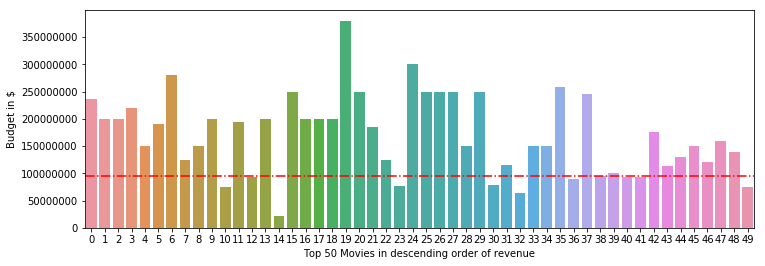

In [112]:
#Graph 1, movies -> budget

#using helper function top50_movies_properties_chart() to plot the bar chart
top50_movies_properties_chart('Budget in $', 'budget', get_percentile(top50_movies_by_revenue.budget, 0.2))

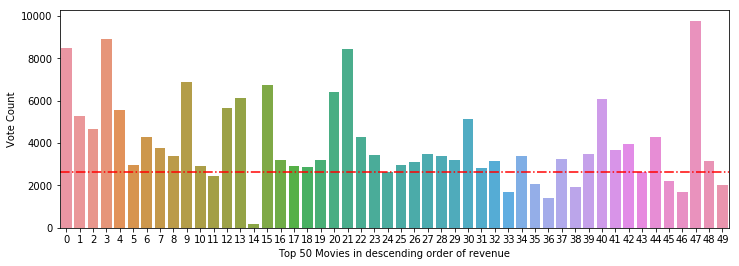

In [113]:
#Graph 2, movies -> vote_count

#using helper function top50_movies_properties_chart() to plot the bar chart
top50_movies_properties_chart('Vote Count', 'vote_count', get_percentile(top50_movies_by_revenue.vote_count, 0.2))

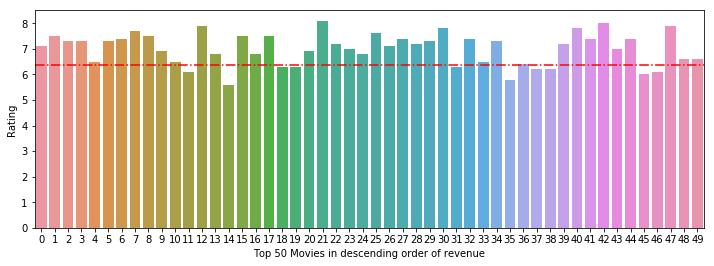

In [114]:
#Graph 3, movies -> vote_average/rating

#using helper function top50_movies_properties_chart() to plot the bar chart
top50_movies_properties_chart('Rating', 'vote_average', get_percentile(top50_movies_by_revenue.vote_average, 0.2))

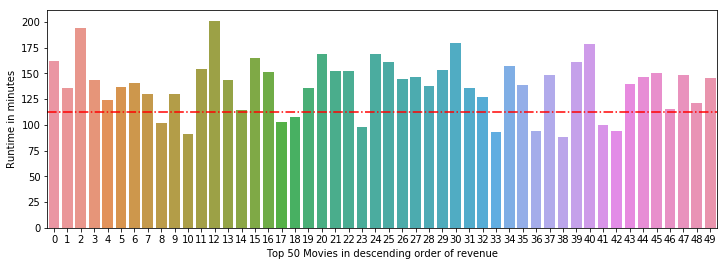

In [115]:
#Graph 4, movies -> runtime

#using helper function top50_movies_properties_chart() to plot the bar chart
top50_movies_properties_chart('Runtime in minutes', 'runtime', get_percentile(top50_movies_by_revenue.runtime, 0.2))

<a id='conclusions'></a>
## Conclusions

> Top 10 highest grossing movies by revenue (without adjusted for inflation) 

In [116]:
#here i am only printing movie titles
print top10_movies_df['original_title']

0                                          Avatar
1                    Star Wars: The Force Awakens
2                                         Titanic
3                                    The Avengers
4                                  Jurassic World
5                                       Furious 7
6                         Avengers: Age of Ultron
7    Harry Potter and the Deathly Hallows: Part 2
8                                          Frozen
9                                      Iron Man 3
Name: original_title, dtype: object


> Top 10 highest grossing movies by revenue (with adjusted for inflation)

In [117]:
##here i am only printing movie titles
print top10_movies_df_adj['original_title']

0                            Avatar
1                         Star Wars
2                           Titanic
3                      The Exorcist
4                              Jaws
5      Star Wars: The Force Awakens
6        E.T. the Extra-Terrestrial
7                           The Net
8    One Hundred and One Dalmatians
9                      The Avengers
Name: original_title, dtype: object


> Genres with number of movies made in that

In [118]:
print genres_with_genre_count_df

                    0
Action           2385
Adventure        1471
Animation         699
Comedy           3793
Crime            1355
Documentary       520
Drama            4761
Family           1231
Fantasy           916
Foreign           188
History           334
Horror           1637
Music             408
Mystery           810
Romance          1712
Science Fiction  1230
TV Movie          167
Thriller         2908
War               270
Western           165


> Common properties of high revenue movies
- These properties are filterd based on only top 40(80%) movies. So, we cannot conclude/predict anything like, if we make movie with budget over $100 million then it is sure to earn high revenue. Also, it is not necessary that this properties are 100% true.

- Budget > ~$95 million
- Vote count > ~2600
- Ratings > ~6.4 (out of 10)
- Runtime > ~110 minutes
- Common genres : 'Adventure', 'Action'

## This concludes my Report!